<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/6%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

총 500개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 500

SBP (수축기 혈압):
  - 평균: 124.91 mmHg
  - 최소: 100.14 mmHg
  - 최대: 145.01 mmHg
  - 표준편차: 5.93 mmHg

DBP (이완기 혈압):
  - 평균: 74.78 mmHg
  - 최소: 64.28 mmHg
  - 최대: 85.97 mmHg
  - 표준편차: 3.62 mmHg


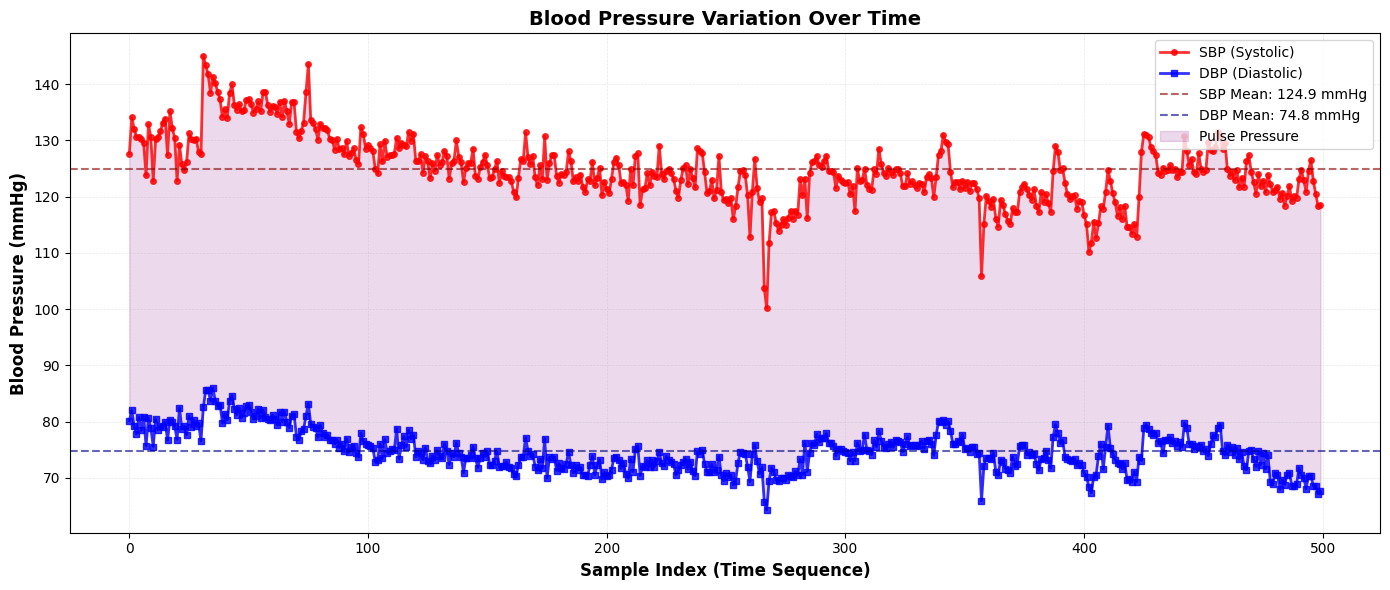


로드 완료: 500개의 PPG 세그먼트


In [43]:
def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()


def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


# ============ 실행 예제 ============
if __name__ == '__main__':
    # 파일 경로 설정
    MAT_FILE = "/content/drive/MyDrive/p014714.mat"

    # 데이터 로드 및 표시 (500개 세그먼트만)
    segments, sbp_values, dbp_values = load_and_display_bp(
        mat_path=MAT_FILE,
        segment_limit=500
    )

    print(f"\n로드 완료: {len(segments)}개의 PPG 세그먼트")

In [44]:
def load_ppg_ecg_bp(mat_path, segment_limit=None):
    segments_ppg, segments_ecg, sbp_list, dbp_list = [], [], [], []

    with h5py.File(mat_path, 'r') as f:
        subj = f['Subj_Wins']
        refs_ppg = subj['PPG_F'][0]
        refs_ecg = subj['ECG_F'][0]
        sbps = subj['SegSBP'][0]
        dbps = subj['SegDBP'][0]

        total = min(len(refs_ppg), segment_limit) if segment_limit else len(refs_ppg)
        print(f"총 {total} 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs_ppg[i]][()].squeeze().astype(np.float32)
            ecg = f[refs_ecg[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments_ppg.append(ppg)
            segments_ecg.append(ecg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    return np.array(segments_ppg), np.array(segments_ecg), np.array(sbp_list), np.array(dbp_list)


In [45]:
def build_cnn(input_shape, output_dim=1):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

def build_cnn_lstm(input_shape, output_dim=1):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(128, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model


In [46]:
def cross_validation_evaluation(X, y, model_type='cnn', n_folds=5, epochs=10, batch_size=32):
    n_samples = X.shape[0]
    fold_size = n_samples // n_folds
    mae_list, rmse_list = [], []

    for fold in range(n_folds):
        start, end = fold*fold_size, (fold+1)*fold_size
        test_idx = np.arange(start, end)
        train_idx = np.setdiff1d(np.arange(n_samples), test_idx)

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # 모델 초기화
        if model_type == 'cnn':
            model = build_cnn(X_train.shape[1:])
        elif model_type == 'cnn_lstm':
            model = build_cnn_lstm(X_train.shape[1:])
        else:
            raise ValueError("model_type must be 'cnn' or 'cnn_lstm'")

        # 학습
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # 예측
        y_pred = model.predict(X_test).squeeze()

        # 평가
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae_list.append(mae)
        rmse_list.append(rmse)

        print(f"Fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}")

    print(f"\n평균 ± 표준편차:")
    print(f"MAE: {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
    print(f"RMSE: {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Assuming numpy is used here but not imported

if __name__ == '__main__':
    MAT_FILE = "/content/drive/MyDrive/p014714.mat"
    segments_ppg, segments_ecg, sbp_values, dbp_values = load_ppg_ecg_bp(MAT_FILE, segment_limit=500)

    # 데이터 형태 맞추기: (samples, timesteps, channels)
    X_ppg = segments_ppg[..., np.newaxis]              # PPG only
    X_ecg_ppg = np.stack([segments_ecg, segments_ppg], axis=2)  # ECG + PPG

    print("\n=== PPG Only 모델 5-Fold CV ===")
    cross_validation_evaluation(X_ppg, sbp_values, model_type='cnn', epochs=5)

    print("\n=== ECG + PPG CNN+LSTM 모델 5-Fold CV ===")
    cross_validation_evaluation(X_ecg_ppg, sbp_values, model_type='cnn_lstm', epochs=5)

총 500 세그먼트 로드 중...

=== PPG Only 모델 5-Fold CV ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 1: MAE=6.23, RMSE=7.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 2: MAE=2.56, RMSE=3.49


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 3: MAE=5.91, RMSE=9.40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 4: MAE=7.76, RMSE=9.76


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 5: MAE=6.08, RMSE=7.80

평균 ± 표준편차:
MAE: 5.71 ± 1.71
RMSE: 7.53 ± 2.23

=== ECG + PPG CNN+LSTM 모델 5-Fold CV ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
Fold 1: MAE=104.76, RMSE=104.86


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Fold 2: MAE=103.10, RMSE=103.13


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Fold 3: MAE=94.47, RMSE=94.59


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Fold 4: MAE=98.23, RMSE=98.30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
